In [1]:
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from tensorflow.keras.layers import BatchNormalization, Conv2D, Layer, Input, AveragePooling2D, GlobalAveragePooling2D, Lambda, subtract, Flatten, Dense, Concatenate, Add
from tensorflow.keras.metrics import AUC, Precision, Recall
import matplotlib.pyplot as plt


c:\Users\kmhas\.conda\envs\Cudaenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
    
physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


In [3]:
@tf.function
def hard_tanh(x):
    return tf.maximum(tf.minimum(x, 1), -1)

# Define the feature extraction layer with residual block
class featureExtractionLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
        self.bn2 = BatchNormalization()
        
        # Residual Block
        self.res_conv = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')
        self.res_bn = BatchNormalization()

        # Activation
        self.activation = Lambda(hard_tanh)

    def call(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Residual Block
        res = self.res_conv(x)
        res = self.res_bn(res)
        x = Add()([x, res])  # Adding the input to the output of the residual block
        
        x = self.activation(x)
        return x

1/1 [==============================] - 0s 21ms/step


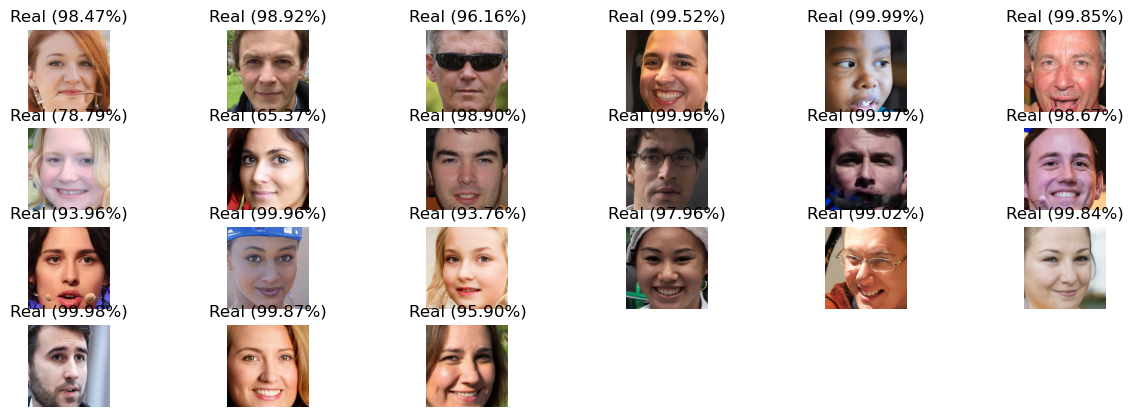

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f
import tempfile

# Load the saved model
model = load_model('./useful_files/best_model.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})

# Load OpenCV Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        print("No faces found in the image.")
        return None, None
    x, y, w, h = faces[0]  
    face_img = img[y:y+h, x:x+w]
    _, temp_path = tempfile.mkstemp(suffix='.jpg')
    cv2.imwrite(temp_path, face_img)
    return face_img, temp_path

def preprocess_single_image(image_path):
    rt, pt = smash_n_reconstruct(image_path)
    frt = tf.cast(tf.expand_dims(f.apply_all_filters(rt), axis=-1), dtype=tf.float64)
    fpt = tf.cast(tf.expand_dims(f.apply_all_filters(pt), axis=-1), dtype=tf.float64)
    return {'rich_texture': tf.expand_dims(frt, axis=0), 'poor_texture': tf.expand_dims(fpt, axis=0)}

def plot_images_with_predictions(image_paths, predictions, rows=2, cols=5):
    plt.figure(figsize=(15, 10))
    for i, (path, pred) in enumerate(zip(image_paths, predictions)):
        face_img, _ = detect_and_crop_face(path)
        if face_img is None:
            continue
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        confidence = pred[0].squeeze()
        predicted_label = 'Fake' if confidence > 0.5 else 'Real'
        confidence_percent = (1 - confidence if predicted_label == 'Real' else confidence) * 100
        plt.title(f"{predicted_label} ({confidence_percent:.2f}%)")
        plt.axis('off')
    plt.show()


path_test_ai = 'C:/Users/kmhas/OneDrive/Desktop/dataset_pfe/small_data/fake'
path_test_real = 'C:/Users/kmhas/OneDrive/Desktop/dataset_pfe/dataset3/dataset/dataset3/test/real'
ai_images = [os.path.join(path_test_ai, img) for img in os.listdir(path_test_ai)[::48]]
real_images = [os.path.join(path_test_real, img) for img in os.listdir(path_test_real)[:6]]
all_images = ai_images 

predictions = []
for image_path in all_images:
    _, temp_path = detect_and_crop_face(image_path)
    if temp_path is None:
        predictions.append([0])
        continue
    preprocessed_input = preprocess_single_image(temp_path)
    pred = model.predict(preprocessed_input)
    predictions.append(pred)
    # os.unlink(temp_path)

plot_images_with_predictions(all_images, predictions, rows=8, cols=6)


In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f
import tempfile

# Load the saved model
model = load_model('./useful_files/best_model.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})

# Load OpenCV Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        print("No faces found in the image.")
        return None, None
    x, y, w, h = faces[0]  
    face_img = img[y:y+h, x:x+w]
    _, temp_path = tempfile.mkstemp(suffix='.jpg')
    cv2.imwrite(temp_path, face_img)
    return face_img, temp_path

def preprocess_single_image(image_path):
    rt, pt = smash_n_reconstruct(image_path)
    frt = tf.cast(tf.expand_dims(f.apply_all_filters(rt), axis=-1), dtype=tf.float64)
    fpt = tf.cast(tf.expand_dims(f.apply_all_filters(pt), axis=-1), dtype=tf.float64)
    return {'rich_texture': tf.expand_dims(frt, axis=0), 'poor_texture': tf.expand_dims(fpt, axis=0)}

def plot_images_with_predictions(image_paths, predictions):
    fake_images = []
    fake_confidences = []
    for path, pred in zip(image_paths, predictions):
        confidence = pred[0].squeeze()
        if confidence > 0.5:  # Filter to show only 'Fake' detected faces
            _, temp_path = detect_and_crop_face(path)
            if temp_path:
                fake_images.append(temp_path)
                fake_confidences.append(confidence * 100)
                os.unlink(temp_path)  # Clean up the temp file after use

    num_fakes = len(fake_images)
    if num_fakes > 0:
        cols = 3  # You can adjust the number of columns based on your display preference
        rows = (num_fakes + cols - 1) // cols
        plt.figure(figsize=(15, 5 * rows))
        for i, (img_path, conf) in enumerate(zip(fake_images, fake_confidences)):
            img = cv2.imread(img_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Fake ({conf:.2f}%)")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No 'Fake' faces detected in the dataset.")

path_test_ai = 'C:/Users/kmhas/OneDrive/Desktop/dataset_pfe/dataset3/dataset/dataset3/test/fake'
path_test_real = 'C:/Users/kmhas/OneDrive/Desktop/dataset_pfe/dataset3/dataset/dataset3/test/real'
ai_images = [os.path.join(path_test_ai, img) for img in os.listdir(path_test_ai)]
real_images = [os.path.join(path_test_real, img) for img in os.listdir(path_test_real)]

all_images = ai_images 

predictions = []
for image_path in all_images[:100] :
    face_img, temp_path = detect_and_crop_face(image_path)
    if temp_path is None:
        predictions.append([0])  # Default prediction if no face is detected
        continue
    preprocessed_input = preprocess_single_image(temp_path)
    pred = model.predict(preprocessed_input)
    predictions.append(pred)

plot_images_with_predictions(all_images, predictions)


OSError: [Errno 24] Too many open files: 'C:\\Users\\kmhas\\AppData\\Local\\Temp\\tmpppvm0dhh.jpg'

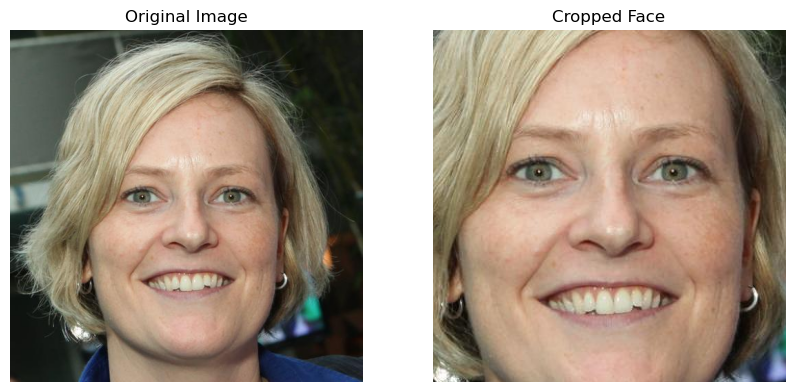

In [20]:
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image_path):
    # Load the Haar cascade file for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Read the image
    img = cv2.imread(image_path)
    # Convert to grayscale (Haar cascade requires grayscale images)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    
    # Check if any faces are detected
    if len(faces) == 0:
        print("No faces found in the image.")
        return None
    
    # For simplicity, consider only the first detected face
    (x, y, w, h) = faces[0]
    # Crop the face region from the image
    face_img = img[y:y+h, x:x+w]
    
    # Convert color back to RGB (matplotlib expects RGB images)
    face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    
    # Plot the original and cropped images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(face_img_rgb)
    plt.title('Cropped Face')
    plt.axis('off')
    
    plt.show()

    # Return the cropped face image
    return face_img_rgb

# Specify the path to your image
image_path = 'C:/Users/kmhas/OneDrive/Desktop/dataset_pfe/dataset3/dataset/dataset3/test/real/00018.jpg'
cropped_face = detect_and_crop_face(image_path)


1/1 [==============================] - 0s 31ms/step


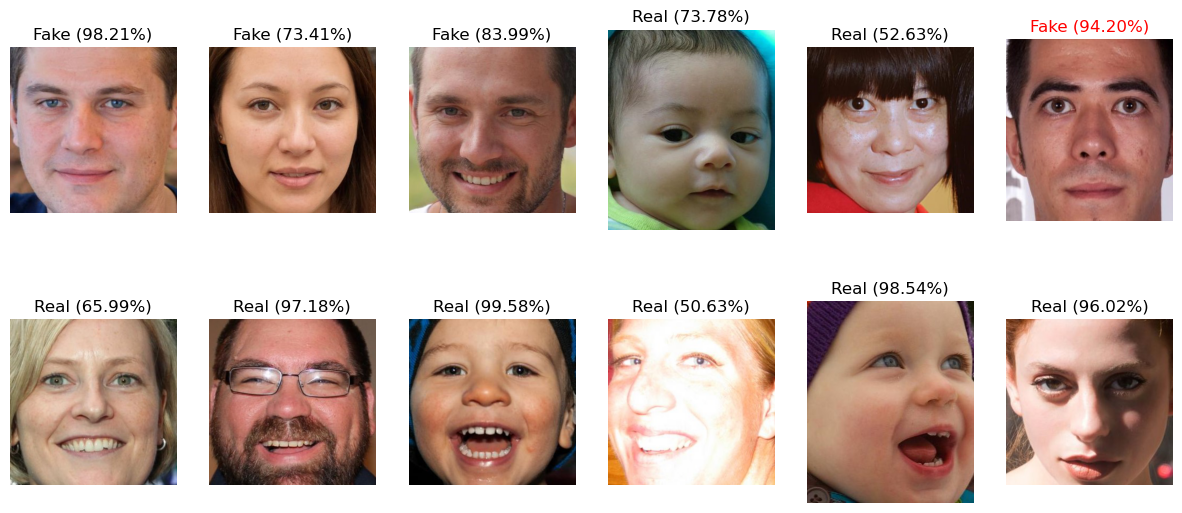

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f

# Load the saved model
model = load_model('./useful_files/best_model.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})

# Define a function to preprocess a single image
def preprocess_single_image(image_path):
    rt, pt = smash_n_reconstruct(image_path)
    frt = tf.cast(tf.expand_dims(f.apply_all_filters(rt), axis=-1), dtype=tf.float64)
    fpt = tf.cast(tf.expand_dims(f.apply_all_filters(pt), axis=-1), dtype=tf.float64)
    return {'rich_texture': tf.expand_dims(frt, axis=0), 'poor_texture': tf.expand_dims(fpt, axis=0)}

# Function to plot images with predicted labels and prediction confidence as percentage
def plot_images_with_predictions(image_paths, predictions, rows=2, cols=5):
    plt.figure(figsize=(15, 10))
    for i, (path, pred) in enumerate(zip(image_paths, predictions)):
        plt.subplot(rows, cols, i + 1)
        image = plt.imread(path)
        plt.imshow(image, cmap='gray')
        
        # Predicted label and confidence extraction
        confidence = pred[0].squeeze()
        predicted_label = 'Fake' if confidence > 0.5 else 'Real'
        # Confidence adjustment for display
        confidence_percent = (1 - confidence if predicted_label == 'Real' else confidence) * 100
        
        # Determine the correctness of the prediction (assuming folder names include 'fake' or 'real')
        actual_label = 'Fake' if 'fake' in path.lower() else 'Real'
        correct_prediction = (predicted_label == actual_label)
        
        # Set title color based on correctness
        title_color = 'red' if not correct_prediction else 'black'
        
        plt.title(f"{predicted_label} ({confidence_percent:.2f}%)", color=title_color)
        plt.axis('off')
    plt.show()

# Folder paths
path_test_ai = 'C:/Users/kmhas/OneDrive/Desktop/fake'
path_test_real = 'C:/Users/kmhas/OneDrive/Desktop/real'

# Collect all image paths
ai_images = [os.path.join(path_test_ai, img) for img in os.listdir(path_test_ai)]
real_images = [os.path.join(path_test_real, img) for img in os.listdir(path_test_real)]

all_images = ai_images + real_images

# Make predictions on each image
predictions = []
for image_path in all_images:
    preprocessed_input = preprocess_single_image(image_path)
    pred = model.predict(preprocessed_input)
    predictions.append(pred)

# Plot the images with their predictions and confidences as percentages
plot_images_with_predictions(all_images, predictions, rows=3, cols=6)


In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, Input, Dense, GlobalAveragePooling2D, AveragePooling2D, Activation
from tensorflow.keras.models import Model

# Define input layers
input1 = Input(shape=(256, 256, 1), name="rich_texture")
input2 = Input(shape=(256, 256, 1), name="poor_texture")

# Feature extraction for rich texture
l1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input1)
l1 = BatchNormalization()(l1)
l1 = Conv2D(32, (3, 3), activation='relu', padding='same')(l1)
l1 = BatchNormalization()(l1)
l1 = Conv2D(64, (3, 3), activation='relu', padding='same')(l1)
l1 = BatchNormalization()(l1)

# Feature extraction for poor texture
l2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input2)
l2 = BatchNormalization()(l2)
l2 = Conv2D(32, (3, 3), activation='relu', padding='same')(l2)
l2 = BatchNormalization()(l2)
l2 = Conv2D(64, (3, 3), activation='relu', padding='same')(l2)
l2 = BatchNormalization()(l2)

# Subtract rich and poor features
contrast = Activation('relu')(Add()([l1, l2]))

# Additional Conv2D layers
x = Conv2D(128, (3, 3), activation='relu', padding='same')(contrast)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Pooling layers
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)     
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Final dense layer
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=[input1, input2], outputs=output, name="rich_texture_poor_texture_contrast")

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

with tf.device('/GPU:0'):
        model.compile(optimizer='adam', 
                    loss='BinaryCrossentropy', 
                    metrics=['accuracy'])
                    #metrics=['accuracy', Precision(), Recall(), AUC()])

# Model summary
model.summary()


Model: "rich_texture_poor_texture_contrast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rich_texture (InputLayer)      [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 poor_texture (InputLayer)      [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['rich_texture[0][0]']           
                                )                                

In [7]:
# Paths for training datasets
path_ai_train = '../dataset3/train/fake'
path_real_train = '../dataset3/train/real'

# Load training images and labels
ai_imgs_train = [os.path.join(path_ai_train, img) for img in os.listdir(path_ai_train)]
ai_label_train = [1 for _ in range(len(ai_imgs_train))]
real_imgs_train = [os.path.join(path_real_train, img) for img in os.listdir(path_real_train)]
real_label_train = [0 for _ in range(len(real_imgs_train))]

# Training data
X_train = ai_imgs_train + real_imgs_train
y_train = ai_label_train + real_label_train

# Paths for validation datasets
path_ai_validate = '../dataset3/validate/fake'
path_real_validate = '../dataset3/validate/real'

# Load validation images and labels
ai_imgs_validate = [os.path.join(path_ai_validate, img) for img in os.listdir(path_ai_validate)]
ai_label_validate = [1 for _ in range(len(ai_imgs_validate))]
real_imgs_validate = [os.path.join(path_real_validate, img) for img in os.listdir(path_real_validate)]
real_label_validate = [0 for _ in range(len(real_imgs_validate))]

# Validation data
X_validate = ai_imgs_validate + real_imgs_validate
y_validate = ai_label_validate + real_label_validate


In [8]:

def preprocess(path, label):
    rt, pt = smash_n_reconstruct(path.numpy().decode('utf-8'))
    frt = tf.cast(tf.expand_dims(f.apply_all_filters(rt), axis=-1), dtype=tf.float64)
    fpt = tf.cast(tf.expand_dims(f.apply_all_filters(pt), axis=-1), dtype=tf.float64)
    return frt, fpt, label

In [9]:
def dict_map(X1,X2,y):
    return {
        'rich_texture':X1,
        'poor_texture':X2
    },y

## Making data pipeline

In [10]:
batch_size = 24

dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
           .shuffle(len(X_train))
           .map(lambda filepath, label: tf.py_function(preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]))
           .map(lambda X1, X2, y: (dict_map(X1, X2, y)))
           .map(lambda x, y: ({'rich_texture': tf.ensure_shape(x['rich_texture'], [256, 256, 1]), 
                               'poor_texture': tf.ensure_shape(x['poor_texture'], [256, 256, 1])}, 
                              tf.ensure_shape(y, [])))
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

validation_set = (tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
                  .map(lambda filepath, label: tf.py_function(preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]))
                  .map(lambda X1, X2, y: (dict_map(X1, X2, y)))
                  .map(lambda x, y: ({'rich_texture': tf.ensure_shape(x['rich_texture'], [256, 256, 1]), 
                                      'poor_texture': tf.ensure_shape(x['poor_texture'], [256, 256, 1])}, 
                                     tf.ensure_shape(y, [])))
                  .batch(10)
                  .prefetch(tf.data.AUTOTUNE))

In [11]:
checkpoint_path = "./checkpoints2/model_checkpoint.keras"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True)


## Training the model

In [12]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090 Laptop GPU, compute capability 8.9


In [15]:
# Load the saved model
model = tf.keras.models.load_model('final_model_v2.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})

# # Continue training from where it left off
initial_epoch = 21  # Specify the epoch from which to continue training

with tf.device('/GPU:0'):
        model.compile(optimizer='adam', 
                    loss='BinaryCrossentropy', 
                    metrics=['accuracy'])
                    #metrics=['accuracy', Precision(), Recall(), AUC()])



# Continue training from the saved weights
history = model.fit(dataset, 
                    epochs=35,  # Or any desired number of additional epochs
                    batch_size=1, 
                    validation_data=validation_set, 
                    callbacks=[checkpoint_callback],
                    initial_epoch=initial_epoch)


Epoch 22/35
3500/3500 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9284
Epoch 22: val_loss improved from inf to 0.54131, saving model to ./checkpoints2\model_checkpoint.keras
3500/3500 [==============================] - 19679s 6s/step - loss: 0.1771 - accuracy: 0.9284 - val_loss: 0.5413 - val_accuracy: 0.8210
Epoch 23/35
3500/3500 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9327
Epoch 23: val_loss did not improve from 0.54131
3500/3500 [==============================] - 18124s 5s/step - loss: 0.1671 - accuracy: 0.9327 - val_loss: 0.7913 - val_accuracy: 0.7817
Epoch 24/35
3500/3500 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9357
Epoch 24: val_loss did not improve from 0.54131
3500/3500 [==============================] - 18243s 5s/step - loss: 0.1608 - accuracy: 0.9357 - val_loss: 1.5924 - val_accuracy: 0.6666
Epoch 25/35
3500/3500 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.93

In [ ]:
model.save('./final_model_v2.h5')

In [ ]:
path_test_ai = '../dataset3/test/fake'
test_ai_imgs = [os.path.join(path_test_ai, img) for img in os.listdir(path_test_ai)]
test_ai_label = [1 for i in range(len(test_ai_imgs))]

path_test_real = '../dataset3/test/real'
test_real_imgs = [os.path.join(path_test_real, img) for img in os.listdir(path_test_real)]
test_real_label = [0 for i in range(len(test_real_imgs))]

X_test = test_ai_imgs + test_real_imgs
y_test = test_ai_label + test_real_label


In [ ]:
test_batch_size = 24

test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                .map(lambda filepath, label: 
                     tf.py_function(preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]))
                .map(lambda X1, X2, y: (dict_map(X1, X2, y)))
                .map(lambda x, y: ({'rich_texture': tf.ensure_shape(x['rich_texture'], [256, 256, 1]), 
                               'poor_texture': tf.ensure_shape(x['poor_texture'], [256, 256, 1])}, 
                              tf.ensure_shape(y, [])))
                .batch(test_batch_size)
                .prefetch(tf.data.AUTOTUNE)
               )


In [ ]:
# Load the saved model with custom objects
loaded_model = tf.keras.models.load_model('./final_model_v2.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})

# Evaluate the model using loaded_model
results = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

1167/1167 [==============================] - 4126s 4s/step - loss: 0.5298 - accuracy: 0.8331
Test Loss: 0.5298182964324951, Test Accuracy: 0.8331071138381958


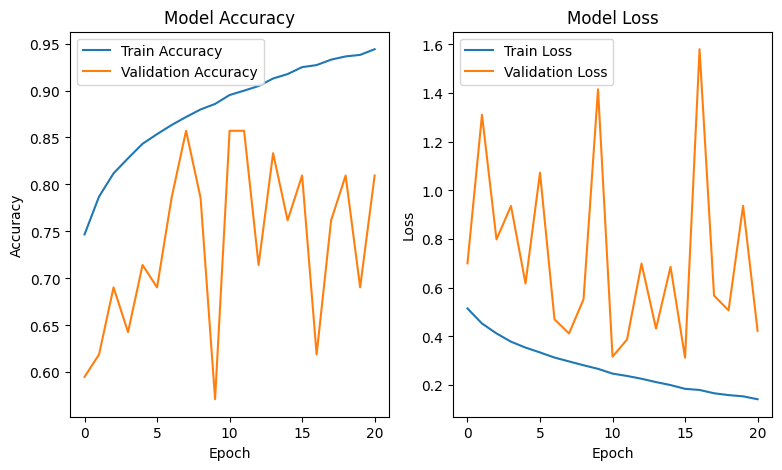

In [ ]:
# Visualize the training history
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

        real       0.79      0.92      0.85     14000
        fake       0.90      0.75      0.82     14000

    accuracy                           0.84     28000
   macro avg       0.85      0.84      0.84     28000
weighted avg       0.85      0.84      0.84     28000



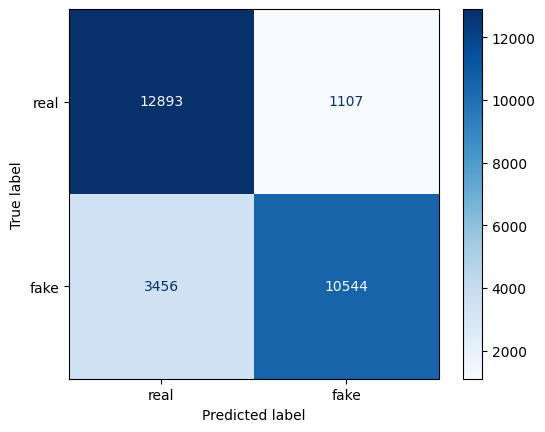

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

# Get the true labels and predictions
y_true = []
y_pred = []

for data, labels in test_dataset:
    predictions = loaded_model.predict(data)
    y_true.extend(labels.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define the labels for the classification report and confusion matrix
cm_plot_labels = ["real", "fake"]

# Print the classification report
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are defined and cm_plot_labels is your list of target names
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

              precision    recall  f1-score   support

        real       0.79      0.92      0.85     14000
        fake       0.90      0.75      0.82     14000

    accuracy                           0.84     28000
   macro avg       0.85      0.84      0.84     28000
weighted avg       0.85      0.84      0.84     28000



In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the checkpoint saved during epoch 27
model_27_v2 = load_model('./checkpoints/model_checkpoint.keras', 
                   custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})

# Now, 'model' contains the architecture and weights from epoch 27.
results_27 = model_27_v2.evaluate(test_dataset)
print(f"Test Loss: {results_27[0]}, Test Accuracy: {results_27[1]}")

1750/1750 [==============================] - 10438s 6s/step - loss: 0.4930 - accuracy: 0.8240
Test Loss: 0.49300989508628845, Test Accuracy: 0.8239642977714539


In [ ]:
model_27_v2.save('./best_model_v2.h5')    

1/1 [==============================] - 0s 21ms/step


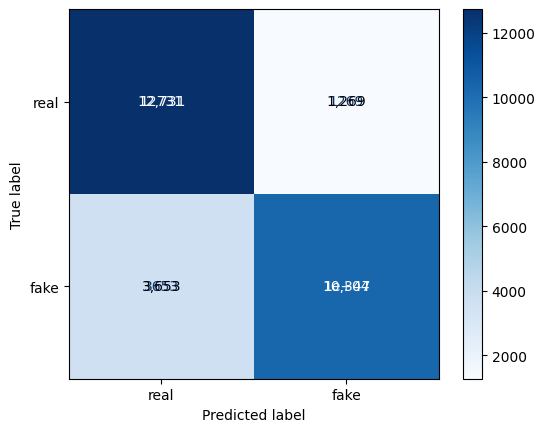

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

# Get the true labels and predictions
y_true = []
y_pred = []

for data, labels in test_dataset:
    predictions = model_27.predict(data)
    y_true.extend(labels.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define the labels for the classification report and confusion matrix
cm_plot_labels = ["real", "fake"]


# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


1/1 [==============================] - 0s 21ms/step


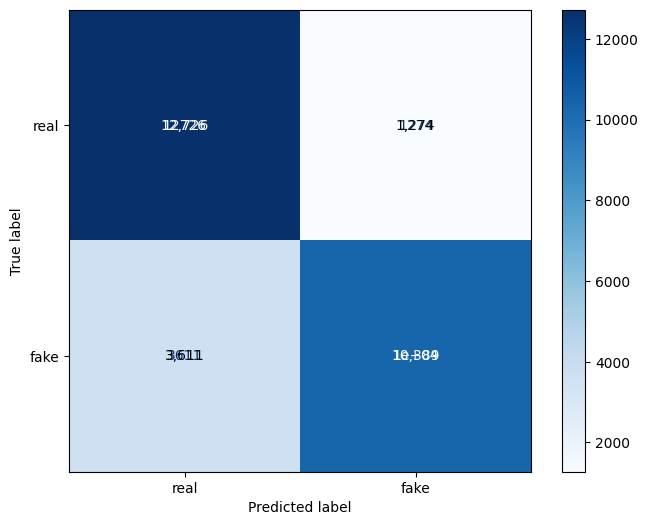

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

# Get the true labels and predictions
y_true = []
y_pred = []

for data, labels in test_dataset:
    predictions = model_27_v2.predict(data)
    y_true.extend(labels.numpy())
    
    # For binary classification, use np.round(predictions)
    y_pred.extend(np.round(predictions).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define the labels for the classification report and confusion matrix
cm_plot_labels = ["real", "fake"]

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Ensure labels are explicitly set for binary classification

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
fig, ax = plt.subplots(figsize=(8, 6))  # Optionally set figure size
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Modify the text annotations to show standard notation
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f'{cm[i, j]:,}', ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.show()


1/1 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

        real       0.78      0.91      0.84     14000
        fake       0.89      0.74      0.81     14000

    accuracy                           0.83     28000
   macro avg       0.83      0.83      0.82     28000
weighted avg       0.83      0.83      0.82     28000



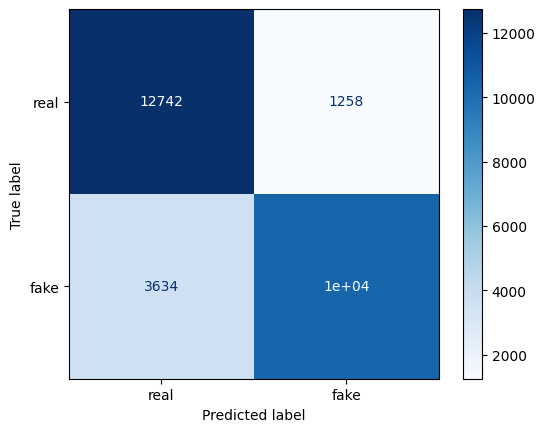

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

# Get the true labels and predictions
y_true = []
y_pred = []

for data, labels in test_dataset:
    predictions = model_27.predict(data)
    y_true.extend(labels.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define the labels for the classification report and confusion matrix
cm_plot_labels = ["real", "fake"]

# Print the classification report
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


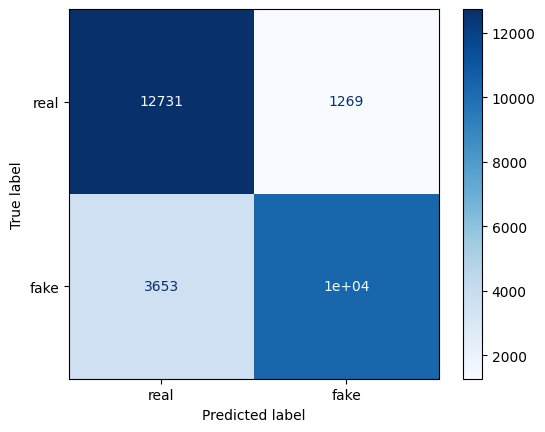

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Convert predictions to binary labels
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Generate the classification report
report = classification_report(y_true, y_pred_binary, target_names=['Real', 'Fake'])
print(report)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred)
print(f"AUC Score: {auc_score}")

              precision    recall  f1-score   support

        Real       0.78      0.91      0.84     14000
        Fake       0.89      0.74      0.81     14000

    accuracy                           0.83     28000
   macro avg       0.83      0.83      0.82     28000
weighted avg       0.83      0.83      0.82     28000

AUC Score: 0.8252857142857143


In [ ]:
from sklearn.metrics import average_precision_score
y_pred_probs = model.predict(test_dataset)
ap_score = average_precision_score(y_true, y_pred_probs)
print(f"Average Precision: {ap_score}")


1750/1750 [==============================] - 14666s 8s/step
Average Precision: 0.9122072488779235


1/1 [==============================] - 0s 17ms/step


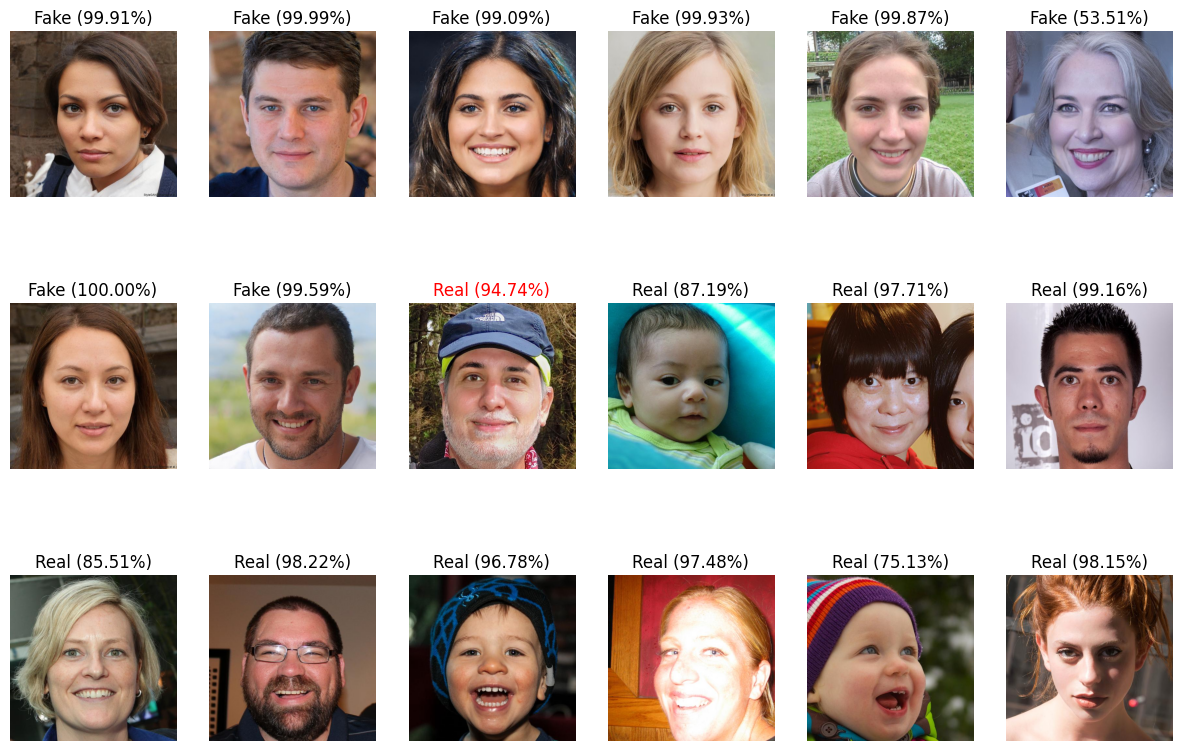

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from preprocessing.patch_generator import smash_n_reconstruct
import preprocessing.filters as f

# Load the saved model
model = load_model('./best_mode l.h5', custom_objects={'featureExtractionLayer': featureExtractionLayer, 'hard_tanh': hard_tanh})


# Define a function to preprocess a single image
def preprocess_single_image(image_path):
    rt, pt = smash_n_reconstruct(image_path)
    frt = tf.cast(tf.expand_dims(f.apply_all_filters(rt), axis=-1), dtype=tf.float64)
    fpt = tf.cast(tf.expand_dims(f.apply_all_filters(pt), axis=-1), dtype=tf.float64)
    return {'rich_texture': tf.expand_dims(frt, axis=0), 'poor_texture': tf.expand_dims(fpt, axis=0)}

# Function to plot images with predicted labels and prediction confidence as percentage
def plot_images_with_predictions(image_paths, predictions, rows=2, cols=5):
    plt.figure(figsize=(15, 10))
    for i, (path, pred) in enumerate(zip(image_paths, predictions)):
        plt.subplot(rows, cols, i + 1)
        image = plt.imread(path)
        plt.imshow(image, cmap='gray')
        
        # Predicted label and confidence extraction
        confidence = pred[0].squeeze()
        predicted_label = 'Fake' if confidence > 0.5 else 'Real'
        # Confidence adjustment for display
        confidence_percent = (1 - confidence if predicted_label == 'Real' else confidence) * 100
        
        # Determine the correctness of the prediction (assuming folder names include 'fake' or 'real')
        actual_label = 'Fake' if 'fake' in path.lower() else 'Real'
        correct_prediction = (predicted_label == actual_label)
        
        # Set title color based on correctness
        title_color = 'red' if not correct_prediction else 'black'
        
        plt.title(f"{predicted_label} ({confidence_percent:.2f}%)", color=title_color)
        plt.axis('off')
    plt.show()

# Folder paths
path_test_ai = '../data_for_testing/fake'
path_test_real = '../data_for_testing/real'

# Collect all image paths
ai_images = [os.path.join(path_test_ai, img) for img in os.listdir(path_test_ai)]
real_images = [os.path.join(path_test_real, img) for img in os.listdir(path_test_real)]

all_images = ai_images + real_images

# Make predictions on each image
predictions = []
for image_path in all_images:
    preprocessed_input = preprocess_single_image(image_path)
    pred = model.predict(preprocessed_input)
    predictions.append(pred)

# Plot the images with their predictions and confidences as percentages
plot_images_with_predictions(all_images, predictions, rows=3, cols=6)
